In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [2]:
# 파일 읽기
olym_df = pd.read_csv("올림픽대로_통행속도_기상.csv", encoding='cp949')

# 결측치 확인
print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())

올림픽대로 결측치 수 :  1279


In [3]:
def fill_missing_values(df):
    # 일시 컬럼을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 추출
    df['hour'] = df['일시'].dt.hour
    
    # 각 결측치에 대해
    null_indices = df[df['속도'].isnull()].index
    
    for idx in null_indices:
        current_row = df.loc[idx]
        
        # 현재 결측치의 조건과 동일한 데이터 필터링
        same_conditions = (
            (df['링크아이디'] == current_row['링크아이디']) & 
            (df['hour'] == current_row['hour']) & 
            (df['isHoliday'] == current_row['isHoliday']) &
            (df['속도'].notnull())  # 결측치가 아닌 데이터만
        )
        
        # 조건에 맞는 평균 속도 계산
        mean_speed = df[same_conditions]['속도'].mean()
        
        # 만약 조건에 맞는 데이터가 없다면 (mean_speed가 NaN이라면)
        # 휴일 조건을 제외하고 다시 계산
        if pd.isna(mean_speed):
            same_conditions = (
                (df['링크아이디'] == current_row['링크아이디']) & 
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 여전히 평균을 구할 수 없다면 전체 링크아이디의 해당 시간대 평균 사용
        if pd.isna(mean_speed):
            same_conditions = (
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 결측치 채우기
        df.loc[idx, '속도'] = mean_speed
        
    return df

# 사용 예시:
olym_df = fill_missing_values(olym_df.copy())

print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())

올림픽대로 결측치 수 :  0


In [4]:
olym_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)

In [5]:
# 속도가 비어있는 행의 인덱스 출력
print("속도가 비어있는 행의 인덱스:")
print(olym_df[olym_df['속도'].isna()].index)

속도가 비어있는 행의 인덱스:
Index([], dtype='int64')


In [7]:
def train_lstm_model(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    LSTM 모델을 학습하고 예측하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        입력 데이터프레임
    target_col : str 
        예측하고자 하는 타겟 컬럼명
    time_steps : int
        시계열 데이터의 시간 스텝 (기본값: 24)
    train_ratio : float
        학습 데이터 비율 (기본값: 0.8)
    epochs : int
        학습 에포크 수 (기본값: 50)
    batch_size : int
        배치 크기 (기본값: 32)
    """
    
    unique_links = df['링크아이디'].unique()
    results = {}
    predictions_df = pd.DataFrame()
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id]
        
        # 데이터 전처리
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(link_df[target_col].values.reshape(-1,1))

        # 시계열 데이터셋 생성
        def create_dataset(data, time_steps=1):
            X, y = [], []
            for i in range(len(data) - time_steps):
                X.append(data[i:(i + time_steps), 0])
                y.append(data[i + time_steps, 0])
            return np.array(X), np.array(y)

        # 시계열 데이터 생성
        X, y = create_dataset(scaled_data, time_steps)

        # 학습/테스트 데이터 분할
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # 데이터 reshape (LSTM 입력 형태로)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # LSTM 모델 구성
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
            LSTM(50, activation='relu'),
            Dense(1)
        ])

        # 모델 컴파일
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0)

        # 예측
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 예측값 역변환
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inv = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test_inv = scaler.inverse_transform([y_test])
        
        # 24시간 미래 예측
        last_sequence = scaled_data[-time_steps:]
        future_predictions = []
        
        current_sequence = last_sequence.reshape((1, time_steps, 1))
        for _ in range(24):  # 24시간 예측
            next_pred = model.predict(current_sequence)
            future_predictions.append(next_pred[0,0])
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[0,-1,0] = next_pred[0,0]
            
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        
        # 예측 결과를 DataFrame에 추가
        temp_df = pd.DataFrame({
            '링크아이디': [link_id] * 24,
            'hour': range(24),
            '예측속도': future_predictions.flatten()
        })
        predictions_df = pd.concat([predictions_df, temp_df])

        # 결과 시각화
        plt.figure(figsize=(15,6))
        plt.plot(y_test_inv.T, label='실제값')
        plt.plot(test_predict, label='예측값')
        plt.title(f'{name} 링크 {link_id} {target_col} 예측 결과')
        plt.xlabel('시간')
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # 모델 평가 결과 저장
        results[link_id] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'Train RMSE': np.sqrt(mean_squared_error(y_train_inv.T, train_predict)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test_inv.T, test_predict)),
                'Train MAE': mean_absolute_error(y_train_inv.T, train_predict),
                'Test MAE': mean_absolute_error(y_test_inv.T, test_predict),
                'Train R2': r2_score(y_train_inv.T, train_predict),
                'Test R2': r2_score(y_test_inv.T, test_predict),
                'Train Adjusted R2': 1 - (1-r2_score(y_train_inv.T, train_predict))*(len(y_train_inv.T)-1)/(len(y_train_inv.T)-X_train.shape[2]-1),
                'Test Adjusted R2': 1 - (1-r2_score(y_test_inv.T, test_predict))*(len(y_test_inv.T)-1)/(len(y_test_inv.T)-X_test.shape[2]-1)
            }
        }
        
        # 평가 결과 출력
        print(f'{name}의 링크 {link_id} 평가 결과:')
        for metric, value in results[link_id]['metrics'].items():
            print(f'{metric}: {value}')
        print('-' * 50)
    
    # 예측 결과를 CSV 파일로 저장
    predictions_df.to_csv(f'{name}_predictions.csv', index=False)
    return results, predictions_df

### 모델 학습


링크아이디 1220005600에 대한 분석


2025-02-15 18:42:37.298371: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 11ms/step


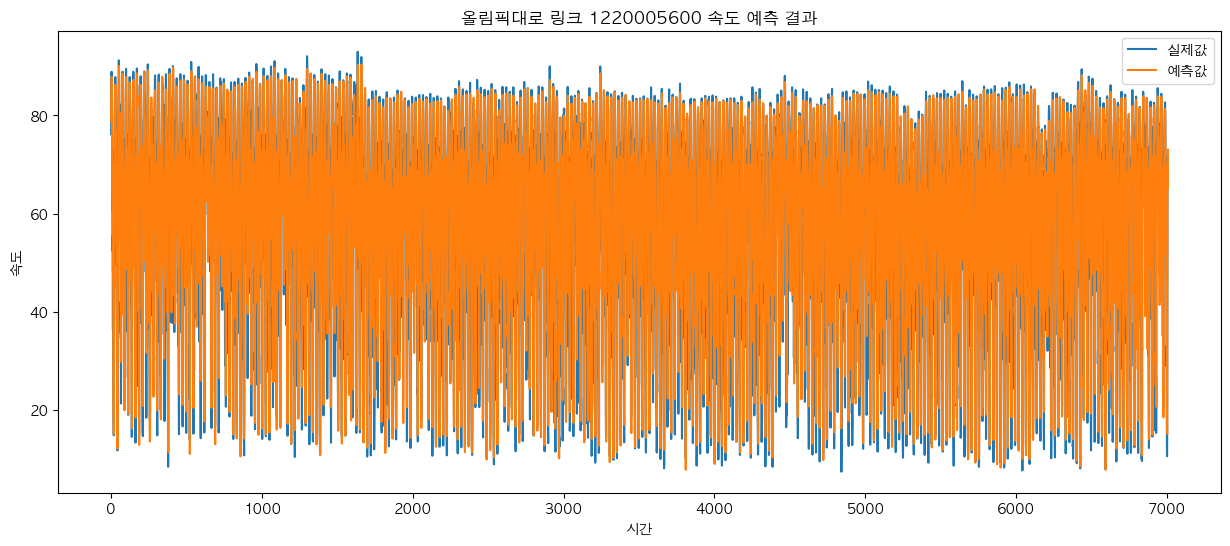

올림픽대로의 링크 1220005600 평가 결과:
Train RMSE: 8.293152253518235
Test RMSE: 8.586107687296591
Train MAE: 5.552111099029488
Test MAE: 5.8269731505832185
Train R2: 0.8612936929455026
Test R2: 0.8633230599199244
Train Adjusted R2: 0.8612887444507807
Test Adjusted R2: 0.8633035513643892
--------------------------------------------------

링크아이디 1220005700에 대한 분석
1/1 [==============================] - 0s 12ms/step


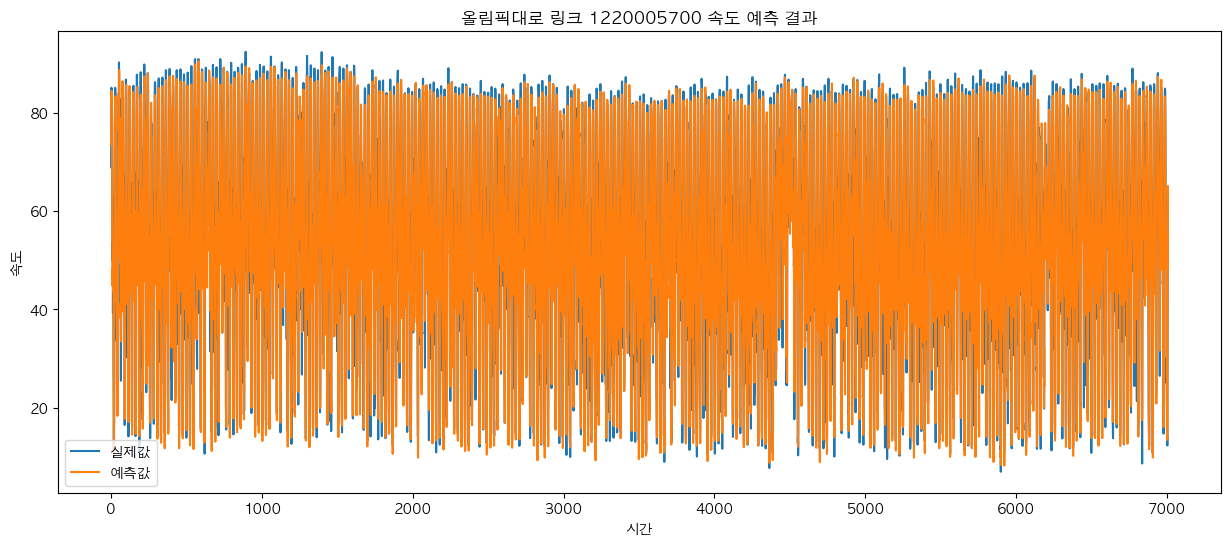

올림픽대로의 링크 1220005700 평가 결과:
Train RMSE: 6.733977364196975
Test RMSE: 6.784397867175031
Train MAE: 4.649205159888303
Test MAE: 4.711793082466953
Train R2: 0.9113101627215024
Test R2: 0.9072802054927196
Train Adjusted R2: 0.9113069986174255
Test Adjusted R2: 0.907266971151511
--------------------------------------------------

링크아이디 1220005400에 대한 분석
1/1 [==============================] - 0s 12ms/step


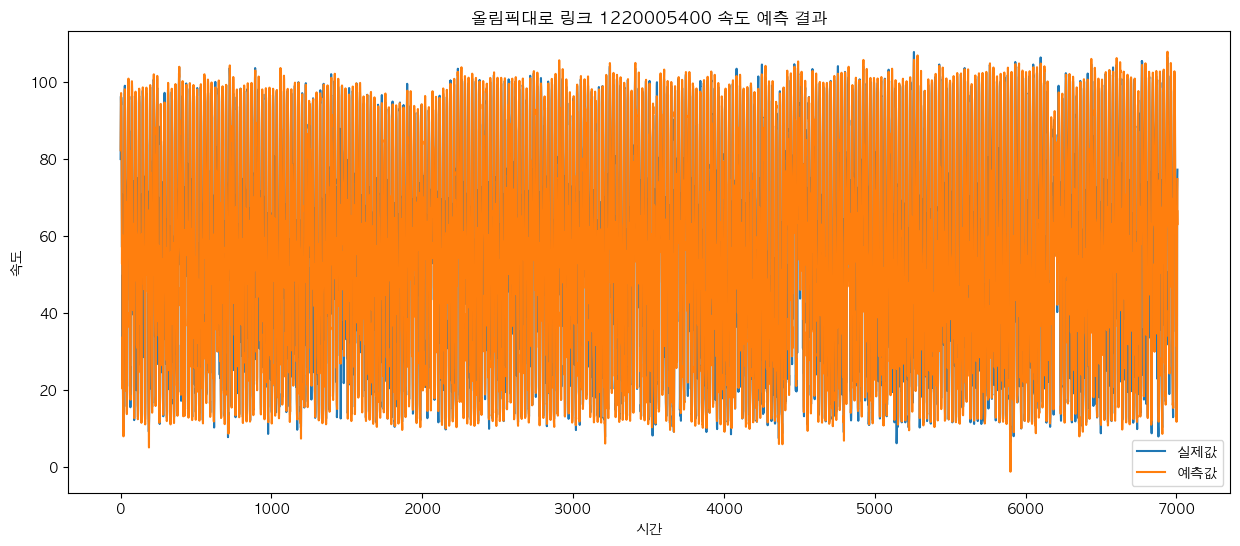

올림픽대로의 링크 1220005400 평가 결과:
Train RMSE: 9.34424258309321
Test RMSE: 10.203352950360667
Train MAE: 6.039016157111757
Test MAE: 6.6076023269632715
Train R2: 0.8998042580276919
Test R2: 0.8926020171093647
Train Adjusted R2: 0.899800683438253
Test Adjusted R2: 0.8925866876798914
--------------------------------------------------

링크아이디 1220004400에 대한 분석
1/1 [==============================] - 0s 11ms/step


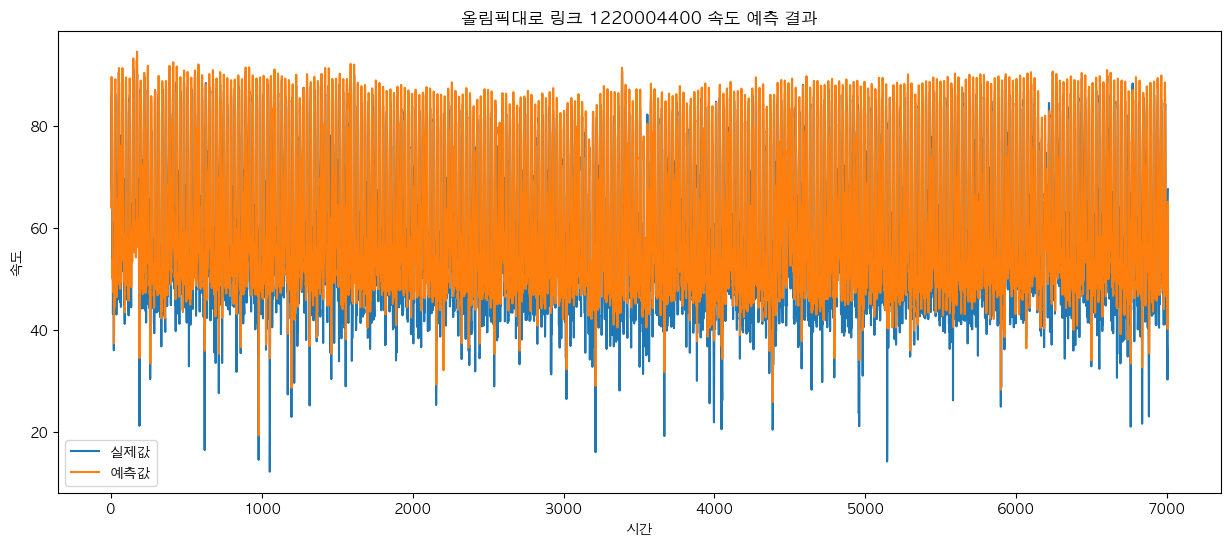

올림픽대로의 링크 1220004400 평가 결과:
Train RMSE: 5.686129363899638
Test RMSE: 5.58431560153136
Train MAE: 4.069365089333358
Test MAE: 4.104887185891156
Train R2: 0.8973723995918187
Test R2: 0.8760805192086857
Train Adjusted R2: 0.897368738243249
Test Adjusted R2: 0.8760628315865344
--------------------------------------------------

링크아이디 1230004500에 대한 분석
1/1 [==============================] - 0s 11ms/step


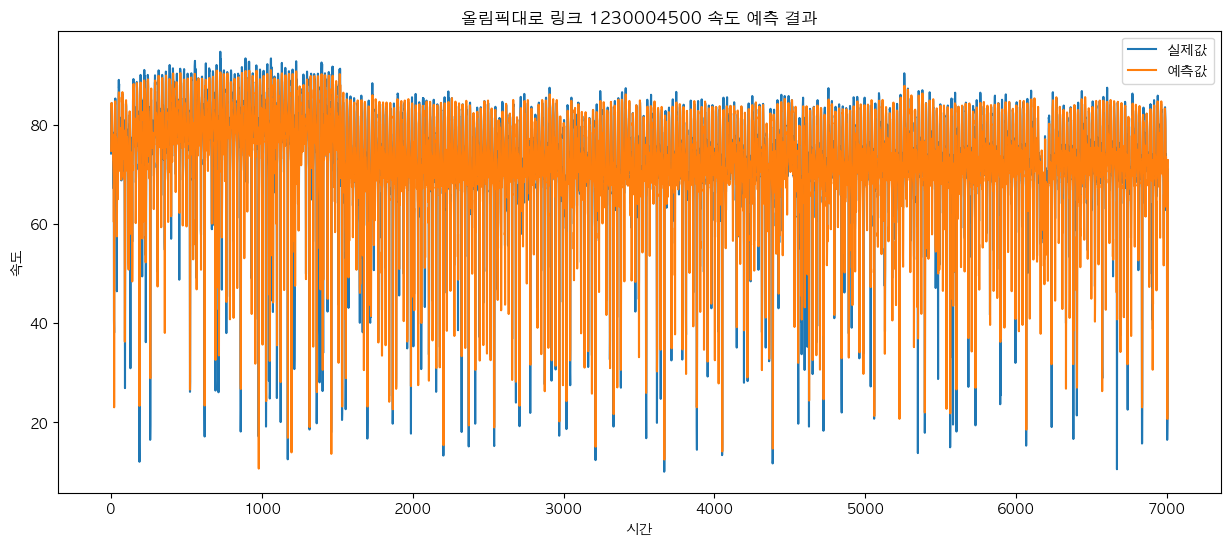

올림픽대로의 링크 1230004500 평가 결과:
Train RMSE: 6.129238814786465
Test RMSE: 5.8289756593314115
Train MAE: 3.3543646965572242
Test MAE: 3.1150148093691037
Train R2: 0.8009878038225773
Test R2: 0.7624409703652444
Train Adjusted R2: 0.8009807038512545
Test Adjusted R2: 0.7624070624249597
--------------------------------------------------

링크아이디 1220005500에 대한 분석
1/1 [==============================] - 0s 12ms/step


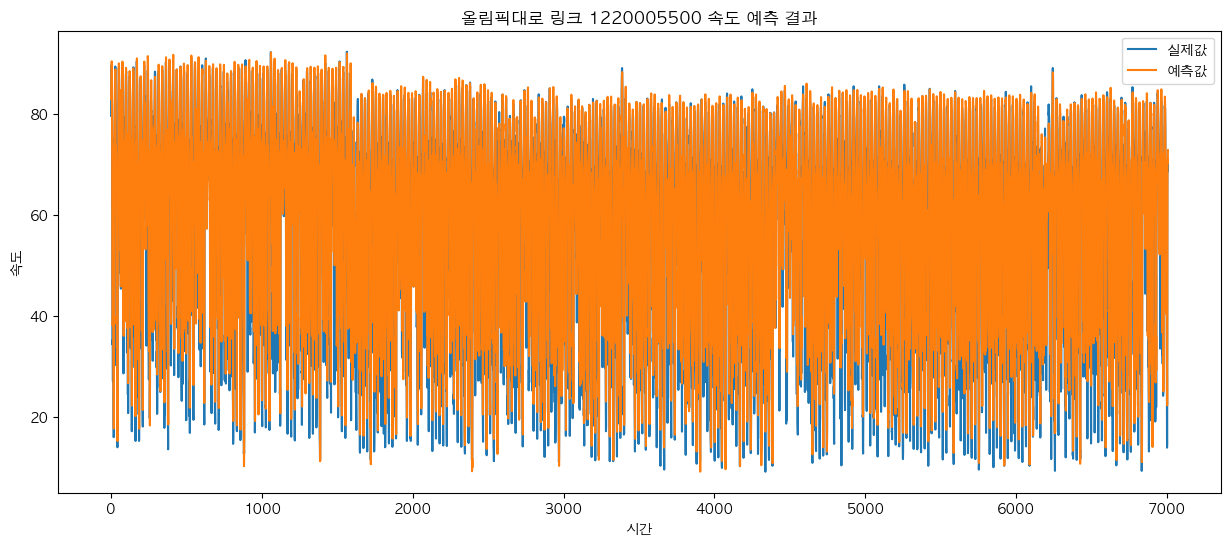

올림픽대로의 링크 1220005500 평가 결과:
Train RMSE: 8.533954226579958
Test RMSE: 8.295577865628497
Train MAE: 5.698960324159539
Test MAE: 5.602675581816185
Train R2: 0.8696408104515853
Test R2: 0.8707466423883797
Train Adjusted R2: 0.8696361597491398
Test Adjusted R2: 0.8707281934363941
--------------------------------------------------

링크아이디 1220004500에 대한 분석
1/1 [==============================] - 0s 11ms/step


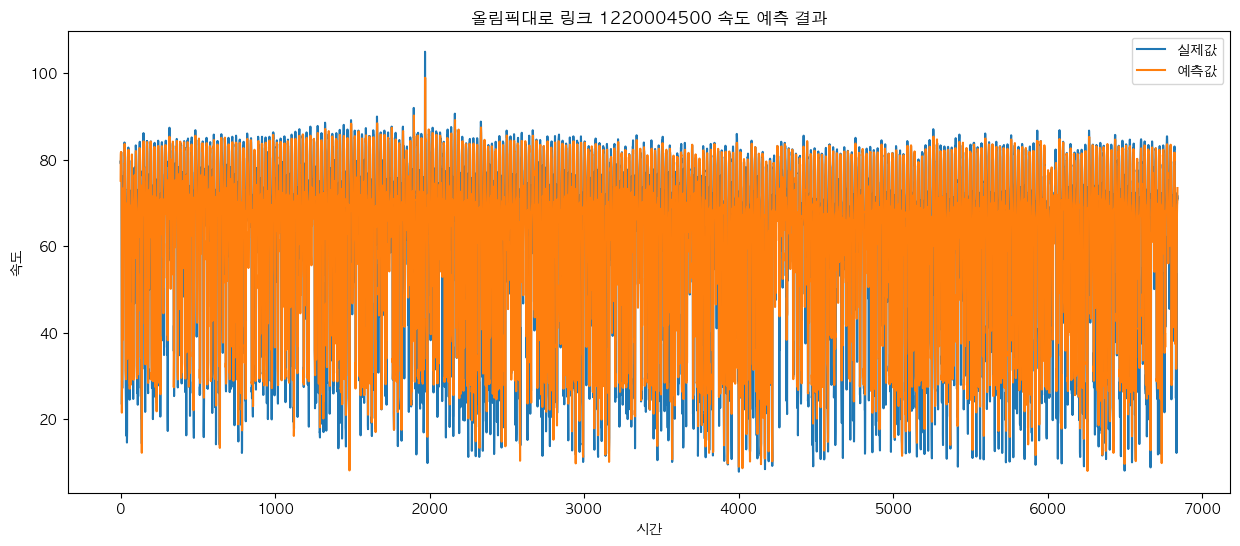

올림픽대로의 링크 1220004500 평가 결과:
Train RMSE: 9.140007001171819
Test RMSE: 9.193000667766041
Train MAE: 5.883476721177214
Test MAE: 5.89280765248311
Train R2: 0.8375226353169373
Test R2: 0.8377509135361201
Train Adjusted R2: 0.8375166963826335
Test Adjusted R2: 0.8377271859715597
--------------------------------------------------

링크아이디 1210006400에 대한 분석
1/1 [==============================] - 0s 11ms/step


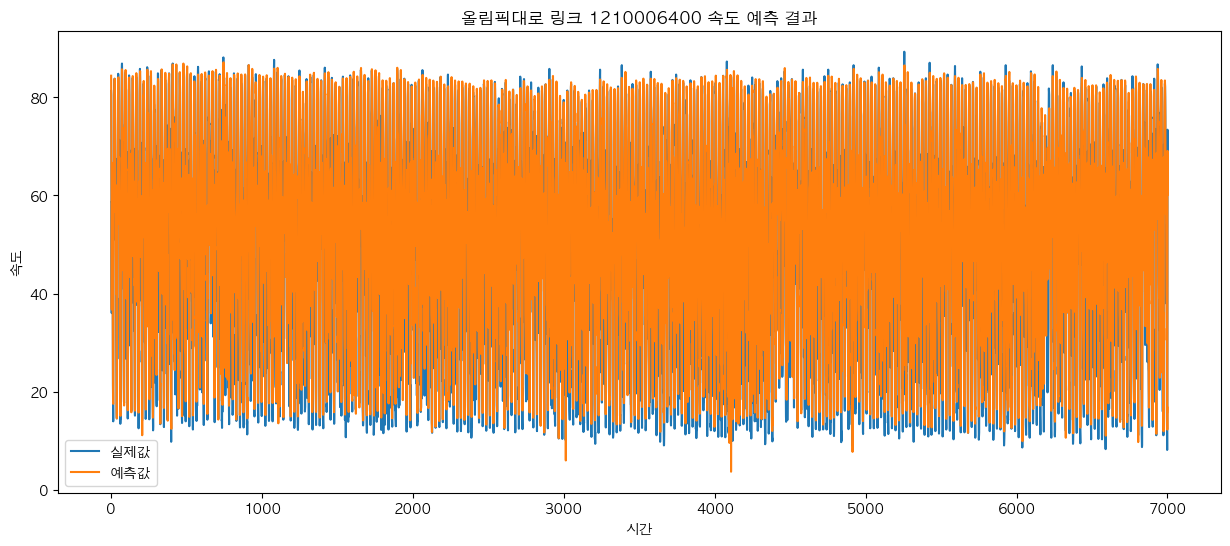

올림픽대로의 링크 1210006400 평가 결과:
Train RMSE: 9.067850933821573
Test RMSE: 9.427485747002397
Train MAE: 6.202945202803211
Test MAE: 6.419210399791696
Train R2: 0.8611646634287865
Test R2: 0.8450039551282253
Train Adjusted R2: 0.8611597067941357
Test Adjusted R2: 0.844981819160663
--------------------------------------------------


In [8]:
results, predictions = train_lstm_model(olym_df, '올림픽대로', target_col='속도')

In [10]:
# 결과를 DataFrame으로 변환
metrics_df = pd.DataFrame()

for link_id, data in results.items():
    metrics = pd.Series(data['metrics'], name=link_id)
    metrics_df = pd.concat([metrics_df, metrics.to_frame().T])

# 인덱스 이름을 '링크아이디'로 설정
metrics_df.index.name = '링크아이디'

# 컬럼 이름을 한글로 변경
metrics_df.columns = [
    '학습 RMSE', '테스트 RMSE',
    '학습 MAE', '테스트 MAE',
    '학습 R2', '테스트 R2',
    '학습 조정R2', '테스트 조정R2'
]

# 소수점 4자리로 반올림
metrics_df = metrics_df.round(3)

# 결과를 보기 좋게 정렬 (RMSE 기준)
metrics_df_sorted = metrics_df.sort_values('테스트 RMSE')


metrics_df_sorted.to_excel('올림픽대로_링크별_평가지표.xlsx')